# Mining Minority-class Examples With Uncertainty Estimates

### This notebook contains the implmenetation of the paper 'Mining Minority-class Examples With Uncertainty Estimates' published in MMM2022.

## Introduction

In the real world, the frequency of occurrence of objects is
naturally skewed forming long-tail class distributions, which results in
poor performance on the statistically rare classes. A promising solution
is to mine tail-class examples to balance the training dataset. However,
mining tail-class examples is a very challenging task. For instance, most
of the otherwise successful uncertainty-based mining approaches struggle
due to distortion of class probabilities resulting from skewness in data.
In this work, we propose an effective, yet simple, approach to overcome
these challenges. Our framework enhances the subdued tail-class activa-
tions and, thereafter, uses a one-class data-centric approach to effectively
identify tail-class examples. We carry out an exhaustive evaluation of our
framework on three datasets spanning over two computer vision tasks.
Substantial improvements in the minority-class mining and fine-tuned
model's task performance strongly corroborate the value of our method.

![](scenario.png)

An illustration of using minority-class mining approach to balance a skewed training dataset. Minority-class mining algorithm takes penultimate-layer activations corresponding to unlabelled data as input and outputs examples which mostly belong to one of the tail-classes. After the human annotator labels these examples, we combine these with the old training dataset (skewed) to obtain a new balanced training dataset. Thereafter, this new dataset can be used to train effective machine learning models.

## Our method

![](method.png)

The proposed minority-class hard example mining framework (shown in the fig above) consists of three major components: (a) the re-calibration layer (RC layer), (b) the minority-class mining autoencoder (MCM-AU), and (c) the decision module. 
First, we use the re-calibration layer to recalibrate the final layer probabilities which are distorted due to class imbalance and overfitting. Specifically, the recalibration layer takes pen-ultimate layer activations of model $M$ as input and outputs the calibrated logits $z \in R^C$.  Second,  we model the calibrated logits $z$ using an autoencoder which acts as an anomaly detector to help separate tail-class examples due to their anomalous activation patterns. Specifically, the calibrated logits $z$, obtained from the recalibration layer, is passed into the autoencoder and a potential reconstruction $\hat{z}$ is obtained as the output. Finally, based on the quality of the reconstruction, instances are flagged as minority-class examples by the decision module. Specifically, it takes the original calibrated logit $z$ and its reconstruction $\hat{z}$ as input, computes the reconstruction error for each example.

## Implementation

### Environment setup

In [1]:
''' Requirements ''' 
!pip install pandas==0.24.2
!pip install torch==1.4.0
!pip install numpy==1.19.5
!pip install easydict==1.7

In [2]:
''' Copy code into the container '''
import sys, os
import moxing as mox
code_dir = '/home/ma-user/work'
mox.file.copy_parallel('obs://vbdai-share/simar/mmm22', code_dir)
!ls

INFO:root:Using MoXing-v2.0.0.rc0-19e4d3ab
INFO:root:Using OBS-Python-SDK-3.20.9.1


acc_plot.png	     helper.py			  pr_cifar.png
accplot.png	     hem_notebook.ipynb		  prcifar.png
cifar-10-batches-py  method.png			  __pycache__
clean_script2.py     mmm22			  saved_model1
common_functions.py  mmm22-cameraready (002).pdf  scenario.png


In [3]:
''' Flags '''
from helper import *
FLAGS = EasyDict()
FLAGS.data_dir = code_dir
FLAGS.datadirname = 'cifar-10-batches-py'
FLAGS.nb_epochs = 20
FLAGS.rc_epochs = 15
FLAGS.batch_size = 64
FLAGS.lr = 1e-3

### Setup data

In [4]:
''' Prepare datset '''
dataloader = CIFAR10DataLoaders(FLAGS)
rl_test = dataloader.combine(dataloader.source_test, dataloader.shifted_test)
rl_input = dataloader.combine(dataloader.source_val, dataloader.shifted_train)

# Distributions: Train, Pool, Test
data = []
data += hist(dataloader.source_train.dataset.targets, display=False)
data += hist(rl_input.dataset.targets, display=False)
data += hist(rl_test.dataset.targets, display=False)
data = '\n'.join(data)

P: [0.0, 0.02, 0.23, 0.69, 0.83, 0.84, 0.85, 0.85, 0.85, 0.85]


/home/ma-user/anaconda3/envs/Pytorch-1.4.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


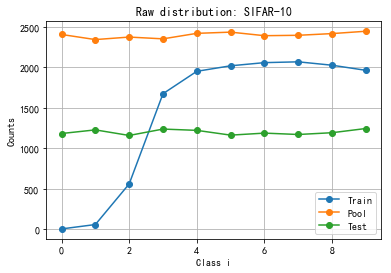

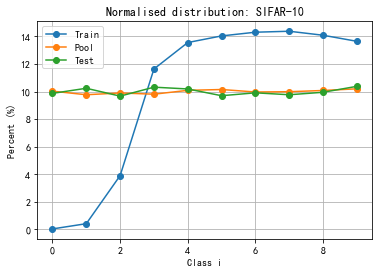

In [5]:
''' Visualise initial data distribution '''
data_list = [x.split(',') for x in data.split('\n')]
raw_numbers = [data_list[0], data_list[2], data_list[4]]
percents = [data_list[1], data_list[3], data_list[5]]
name = 'SIFAR-10'
plt.plot([int(x) for x in raw_numbers[0]], 'o-')
plt.plot([int(x) for x in raw_numbers[1]], 'o-')
plt.plot([int(x) for x in raw_numbers[2]], 'o-')
plt.title('Raw distribution: ' + name)
plt.legend(['Train', 'Pool', 'Test'])
plt.ylabel('Counts')
plt.xlabel('Class i')
plt.grid()
plt.show()
plt.plot([float(x) for x in percents[0]], 'o-')
plt.plot([float(x) for x in percents[1]], 'o-')
plt.plot([float(x) for x in percents[2]], 'o-')
plt.title('Normalised distribution: ' + name)
plt.legend(['Train', 'Pool', 'Test'])
plt.ylabel('Percent (%)')
plt.xlabel('Class i')
plt.grid()
plt.show()

### Train/load target network along with RC layer

In [6]:
nn_model = CIFAR10_SMALLCNN()
source_dataloader = EasyDict(train=dataloader.source_train, test=rl_test)
model = TrainableModel(FLAGS, source_dataloader, nn_model)
if model.device == 'cuda':
    model = model.cuda()
model.loadMyself(epoch=1)
model.short_evaluate(rl_test)

 Loading model:  /home/ma-user/work/saved_model1


/home/ma-user/anaconda3/envs/Pytorch-1.4.0/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'helper.TrainableModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Model Acc on Test (%): 65.392
Derived model Acc on Test (%): 66.258


<img src="acc_plot.png" alt="drawing" width="400" align="left"/>

![](accplot.png)

### Train the hard example mining autoencoder

In [7]:
train_dataset = ModelDataset(model, dataloader.source_train.dataset) # Train dataset (train portion)
test_dataset = ModelDataset(model, dataloader.source_val.dataset) # Train dataset (val portion)
infer_dataset = ModelDataset(model, rl_input.dataset) # Pool set
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=FLAGS.batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=FLAGS.batch_size)
infer_loader = DataLoader(infer_dataset, shuffle=False, batch_size=FLAGS.batch_size)
ae_model = AE_INV_TINY(train_dataset.__getdim__(), train_loader, test_loader, epochs=25)
if ae_model.device == 'cuda':
    ae_model = ae_model.cuda()
ae_model.train_myself()

Epoch: 1/25, Train loss 0.064, Test loss: 0.038
Epoch: 2/25, Train loss 0.020, Test loss: 0.010
Epoch: 3/25, Train loss 0.008, Test loss: 0.005
Epoch: 4/25, Train loss 0.003, Test loss: 0.002
Epoch: 5/25, Train loss 0.002, Test loss: 0.002
Epoch: 6/25, Train loss 0.001, Test loss: 0.001
Epoch: 7/25, Train loss 0.001, Test loss: 0.000
Epoch: 8/25, Train loss 0.000, Test loss: 0.000
Epoch: 9/25, Train loss 0.000, Test loss: 0.000
Epoch: 10/25, Train loss 0.000, Test loss: 0.000
Epoch: 11/25, Train loss 0.000, Test loss: 0.000
Epoch: 12/25, Train loss 0.000, Test loss: 0.000
Epoch: 13/25, Train loss 0.000, Test loss: 0.000
Epoch: 14/25, Train loss 0.000, Test loss: 0.000
Epoch: 15/25, Train loss 0.000, Test loss: 0.000
Epoch: 16/25, Train loss 0.000, Test loss: 0.000
Epoch: 17/25, Train loss 0.000, Test loss: 0.000
Epoch: 18/25, Train loss 0.000, Test loss: 0.000
Epoch: 19/25, Train loss 0.000, Test loss: 0.000
Epoch: 20/25, Train loss 0.000, Test loss: 0.000
Epoch: 21/25, Train loss 0.00

### Mine hard examples from the Pool set and compute stats

In [8]:
scores = ae_model.compute_scores(infer_loader)
ranks = np.argsort(scores)[::-1]
gts = rl_input.dataset.targets

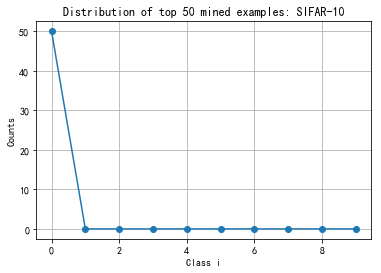

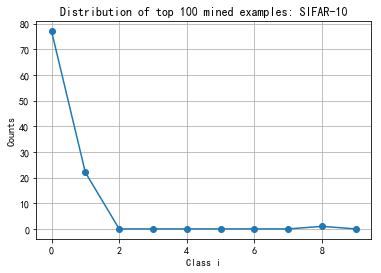

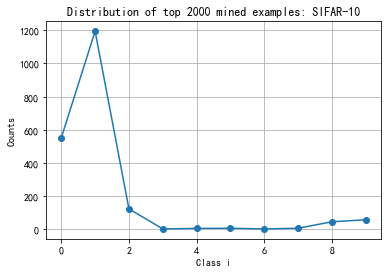

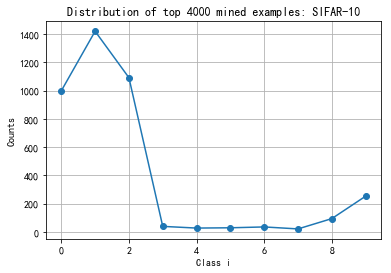

In [11]:
''' Display the mined examples distribution '''
for no_of_exmaples_to_mine in [50, 100, 2000, 4000]:
    raw, percent = hist(gts[ranks[:no_of_exmaples_to_mine]], display=False)
    plt.plot([int(x) for x in raw.split(",")], 'o-')
    plt.title(f'Distribution of top {no_of_exmaples_to_mine} mined examples: SIFAR-10')
    plt.ylabel('Counts')
    plt.xlabel('Class i')
    plt.grid()
    plt.show()

## Conclusion

As you can see in the curve, most of the examples are from the initial classes which are in minority in the intiial train distribution. Our approach is effective in mining hard example mining. For more datasets and more detailed analysis, refer to our paper.